In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import sympy as sym

import pycollocation
import pyam

## Defining inputs

Need to define some heterogenous factors of production...

In [3]:
# define some workers skill
x, loc1, mu1, sigma1 = sym.var('x, loc1, mu1, sigma1')
skill_cdf = 0.5 + 0.5 * sym.erf((sym.log(x - loc1) - mu1) / sym.sqrt(2 * sigma1**2))
skill_params = {'loc1': -1e-1, 'mu1': 0.0, 'sigma1': 1.0}
skill_bounds = [-skill_params['loc1'], 1e2]

workers = pyam.Input(var=x,
                     cdf=skill_cdf,
                     params=skill_params,
                     bounds=skill_bounds,
                     )

# define some firms
y, loc2, mu2, sigma2 = sym.var('y, loc2, mu2, sigma2')
productivity_cdf = 0.5 + 0.5 * sym.erf((sym.log(y - loc2) - mu2) / sym.sqrt(2 * sigma2**2))
productivity_params = {'loc2': -1e-1, 'mu2': 0.0, 'sigma2': 1.0}
productivity_bounds = [-productivity_params['loc2'], 1e2]

firms = pyam.Input(var=y,
                   cdf=productivity_cdf,
                   params=productivity_params,
                   bounds=productivity_bounds,
                   )

## Defining a production process

Next need to define some production process...

In [4]:
# define symbolic expression for CES between x and y
omega_A, sigma_A = sym.var('omega_A, sigma_A')
A = ((omega_A * x**((sigma_A - 1) / sigma_A) + 
     (1 - omega_A) * y**((sigma_A - 1) / sigma_A))**(sigma_A / (sigma_A - 1))) 

# define symbolic expression for CES between x and y
r, l, omega_B, sigma_B = sym.var('r, l, omega_B, sigma_B')
B = ((omega_B * r**((sigma_B - 1) / sigma_B) + 
     (1 - omega_B) * l**((sigma_B - 1) / sigma_B))**(sigma_B / (sigma_B - 1))) 

F = A * B

In [5]:
# positive assortativity requires that sigma_A * sigma_B < 1
F_params = {'omega_A':0.25, 'omega_B':0.5, 'sigma_A':0.5, 'sigma_B':1.0 }

## Define a boundary value problem

In [6]:
problem = pyam.AssortativeMatchingProblem(assortativity='positive',
                                          input1=workers,
                                          input2=firms,
                                          F=sym.limit(F, sigma_B, 1),
                                          F_params=F_params)

## Pick some collocation solver

In [7]:
solver = pycollocation.OrthogonalPolynomialSolver(problem)

## Compute some decent initial guess

In [8]:
initial_guess = pyam.OrthogonalPolynomialInitialGuess(solver)
initial_polys = initial_guess.compute_initial_guess("Chebyshev",
                                                    degrees={'mu': 175, 'theta': 175},
                                                    exp=0.5)

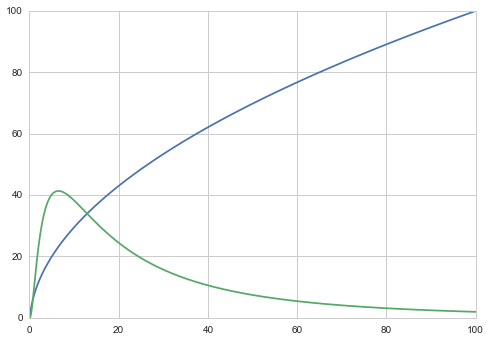

In [9]:
# quickly plot the initial conditions
sn.set_style("whitegrid")
xs = np.linspace(workers.lower, workers.upper, 1000)
plt.plot(xs, initial_polys['mu'](xs))
plt.plot(xs, initial_polys['theta'](xs))
plt.grid('on')

## Solve the model!

In [10]:
domain = [workers.lower, workers.upper]
initial_coefs = {'mu': initial_polys['mu'].coef,
                 'theta': initial_polys['theta'].coef}

solver.solve(kind="Chebyshev",
             coefs_dict=initial_coefs,
             domain=domain,
             method='hybr')

In [11]:
solver.result.success

True

## Plot some results

In [12]:
viz = pycollocation.Visualizer(solver)

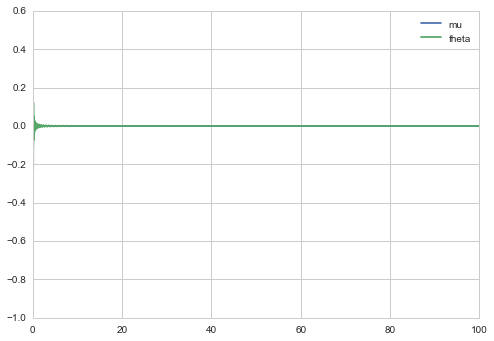

In [13]:
viz.interpolation_knots = np.logspace(-1, 2, 1000)
viz.residuals.plot()
plt.show()

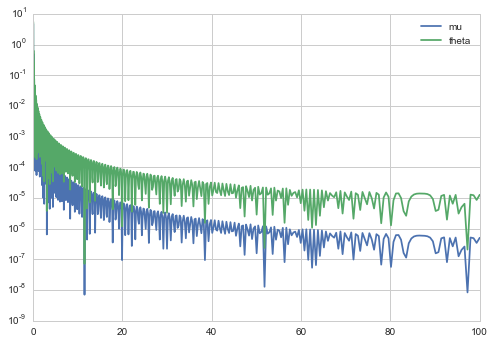

In [14]:
viz.normalized_residuals.plot(logy=True)
plt.show()

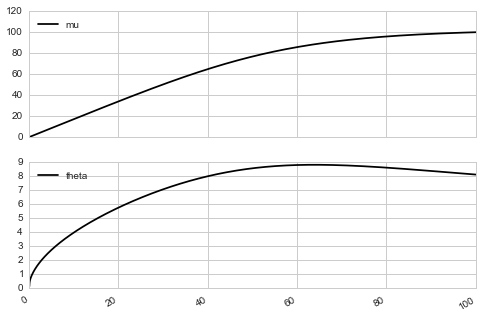

In [15]:
viz.solution.plot(subplots=True)
plt.show()

## Plot the density for firm size

As you can see, the theta function is hump-shaped. Nothing special, but when calculating the pdf some arrangements have to be done for this: sort the thetas preserving the order (so we can relate them to their xs) and then use carefully the right x for calculating the pdf.

The principle of Philipp's trick is:

$pdf_x(x_i)$ can be interpreted as *number of workers with ability x*. $\theta_i$ is the size of the firms that employs workers of kind $x_i$. As all firms that match with workers type $x_i$ choose the same firm size, $pdf_x(x_i)/\theta_i$ is the number of firms of size $\theta_i$.

Say there are 100 workers with ability $x_i$, and their associated firm size $\theta_i$ is 2. Then there are $100/2 = 50$ $ \theta_i$ firms

In [70]:
# philipp's trick in 3 lines...
sorted_data = viz.solution.sort('theta', ascending=True, inplace=False)
theta_pdf = workers.evaluate_pdf(sorted_data.index.values) / sorted_data.theta
theta_cdf = theta_pdf.cumsum() / theta_pdf.sum()

#...survival function is also useful
theta_sf = 1 - theta_cdf

In [72]:
# these might also be useful later...
def emprical_cdf(series):
    sq = series.value_counts()
    cdf = sq.sort_index().cumsum() * (1.0 / series.count())
    return cdf

def empirical_sf(series):
    return 1 - emprical_cdf(series)

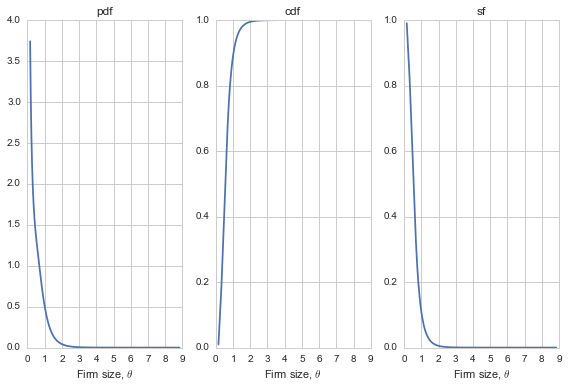

In [86]:
fig, axes = plt.subplots(1, 3)
axes[0].plot(tmp.theta, theta_pdf)
axes[0].set_xlabel(r'Firm size, $\theta$')
axes[0].set_title(r'pdf')

axes[1].plot(tmp.theta, theta_cdf)
axes[1].set_title(r'cdf')
axes[1].set_xlabel(r'Firm size, $\theta$')

axes[2].plot(tmp.theta, theta_sf)
axes[2].set_title(r'sf')
axes[2].set_xlabel(r'Firm size, $\theta$')

plt.tight_layout()
plt.show()

Note: the long (almost invisible) tail of the Cdfs is due to the extreme value of 100 at the end.